# **Feynman GNN project**

Version 8:

Removed redundant code and added the option of running locally rather than from a mounted google drive.

Ray tune not included in this version. See previous version to see old attempted implementation.

## Install and import libraries

In [1]:
%pip install numpy pandas tqdm matplotlib
%pip install tensorboard tensorboardX ipywidgets
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install pytorch-lightning

  Using cached numpy-1.26.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached matplotlib-3.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached contourpy-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.43.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (152 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
  Using cached Pillow-10.1.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached py

In [2]:
%pip install torch_geometric
# Optional dependencies:
%pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

  Using cached torch_geometric-2.4.0-py3-none-any.whl.metadata (63 kB)
  Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached torch_geometric-2.4.0-py3-none-any.whl (1.0 MB)
Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.3/497.3 kB 5.0 MB/s eta 0:00:00 MB/

In [1]:
## Standard libraries
import os
import os.path as osp
import math
import numpy as np 
import pandas as pd
import ast
import random as rnd
from typing import Optional
from tqdm import tqdm


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
#from matplotlib.colors import to_rgb
import matplotlib


# Load the TensorBoard notebook extension
%load_ext tensorboard


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
# Torchvision
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger




# torch geometric
import torch_geometric

    
import torch_geometric.nn as geom_nn
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TopKPooling

matplotlib.rcParams['lines.linewidth'] = 2.0

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"

# Setting the seed
pl.seed_everything(1205)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
torch.__version__

Seed set to 1205


'2.1.0+cpu'

## Feynman Dataset class

In [22]:
class FeynmanDataset(Dataset):
    def __init__(
        self,
        dataset_size: int,
        filename: str,
        root: str=DATASET_PATH,
        num_sampling_bins: int=1,
        reprocess: bool = False,
        transform=None,
        pre_transform=None,
        pre_filter=None
        ):
      """
      Pytorch Geometric Dataset class to store the and access the Feynman diagrams

      Parameters
      ---
      dataset_size (int): size of dataset
      filename (str): csv filename 
      root (str): directory where dataset should be stored. Contains raw data in raw_dir and processed data in processed_dir
      num_sampling_bins (int): Controls number of sampling bins, bin sample size = dataset_size/num_sampling_bins. default=1
      reprocess (bool): reprocess the data. default=False
      transform=None,
      pre_transform=None,
      pre_filter=None
      """
      self.filename = filename
      self.max_trunc_size = 10000
      self.num_sampling_bins = num_sampling_bins
      self.reprocess = reprocess
      self.label=filename[:-4]
      self.dataset_size = dataset_size

      if self.num_sampling_bins>self.dataset_size:
        raise Exception("num_sampling_bins cannot be less than the dataset size")
      
      super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
      #skips download if this is found
      return self.filename

    @property
    def processed_file_names(self):
      #will skip the process method if the following files are found
      if self.reprocess is True:
        if osp.exists(f'{self.processed_dir}/{self.label}_data_0.pt'):
          os.remove(f'{self.processed_dir}/{self.label}_data_0.pt')
        self.reprocess=False
      proc_files = [0]*self.dataset_size
      for idx in range(self.dataset_size):
        proc_files[idx] =  f'{self.label}_data_{idx}.pt'
      return proc_files
      

    def download(self):
        # Download to `self.raw_dir`. In the future I will make this call a
        # python file to build the dataset as a csv
        print("No files to download")
        pass

    def process(self):
      #read csv to pandas dataframe with a converter so that the columns are read as lists rather than strings. Don't convert p column though, because we need to extract the max value
      self.full_data = pd.read_csv(self.raw_paths[0], converters={'x':ast.literal_eval,'edge_attr':ast.literal_eval,'edge_index':ast.literal_eval})

      """
      #strip out the column which holds the momenta
      all_p_values = self.full_data['p'].str.split(',',expand=True)[0].str.strip('[')
      
      #now convert the momenta and angles to lists with literal_eval
      self.full_data['p'] = self.full_data['p'].apply(func=ast.literal_eval)
      all_p_values = all_p_values.apply(ast.literal_eval)
      """
      
      print("Sampling data")
      y_max_full = self.full_data['y'].max()
      y_min_full = self.full_data['y'].min()
      empty_count = 0
      for k in range(self.num_sampling_bins):
        #break dataset up
        self.data_sample = self.full_data[self.full_data['y'] >= ((y_max_full-y_min_full)*(k/self.num_sampling_bins))+y_min_full]
        self.data_sample = self.data_sample[self.data_sample['y'] <= ((y_max_full-y_min_full)*((k+1)/self.num_sampling_bins))+y_min_full]

        if self.data_sample.empty is True:
          empty_count += 1

      sample_size = int(self.dataset_size/self.num_sampling_bins)
      sample_size = sample_size+int(empty_count*sample_size/(self.num_sampling_bins-empty_count))

      for k in range(self.num_sampling_bins):
        #break dataset up
        self.data_sample = self.full_data[self.full_data['y'] >= ((y_max_full-y_min_full)*(k/self.num_sampling_bins))+y_min_full]
        self.data_sample = self.data_sample[self.data_sample['y'] <= ((y_max_full-y_min_full)*((k+1)/self.num_sampling_bins))+y_min_full]

        if self.data_sample.empty is False:

          #take a small sample and append
          if k==0:
            self.data_sample = self.data_sample.sample(n=sample_size, replace=True)
            self.data = self.data_sample
          else:
            self.data_sample = self.data_sample.sample(n=sample_size, replace=True)
            self.data = pd.concat([self.data,self.data_sample],ignore_index=True)

      self.data['y'].hist()

      #truncate dataframe into smaller dataframes
      split_size = math.ceil(self.dataset_size/self.max_trunc_size)
      self.trunc_data_list = np.array_split(self.data, split_size)
      #cycle through graphs and create data objects for each
      idx=0
      for k in tqdm(range(len(self.trunc_data_list))):
        self.trunc_data=self.trunc_data_list[k]
        for row, feyndiag in tqdm(self.trunc_data.iterrows(),total=self.trunc_data.shape[0]):
          #node features
          x = self._get_node_features(feyndiag)
          #edge features
          edge_attr = self._get_edge_features(feyndiag)
          #adjacency list
          edge_index = self._get_adj_list(feyndiag)
          #targets
          y = self._get_targets(feyndiag)
          #target scaler
          y_scaler = self._get_target_scaler(feyndiag)
          #momenta
          p = self._get_momenta(feyndiag)
          #momenta scaler
          p_scaler = self._get_momenta_scaler(feyndiag)
          #angle
          theta = self._get_angle(feyndiag)
          #dummy target values for testing
          dummy = torch.tensor(0.679).view(1,1)

          #normalize the masses
          edge_attr[:,0] = 100*(torch.pow(edge_attr[:,0]+1,0.01)-1)
          
          #create data object (to undo transform, multiiply by scaler and then add shift)
          data = Data(x=x, edge_index = edge_index, edge_attr=edge_attr, y=y, p=p, theta=theta, dummy=dummy, y_scaler=y_scaler, p_scaler=p_scaler)
          #save file
          torch.save(data, osp.join(self.processed_dir, f'{self.label}_data_{idx}.pt'))

          idx+=1

    def _get_node_features(self, diagram):
      """
      This will return a list of the node feature vectors (which are 1D)
      [Number of Nodes, 3]
      """
      x = diagram.loc['x']
      x = torch.tensor(x,dtype=torch.float).view(-1,3)
      return x

    def _get_edge_features(self, diagram):
      """
      This will return a list of the edge feature vectors (which are 9D)
      [m,S,LIW3,LY,RIW3,RY,[r,g,b],anti-[r,g,b]]
      [Number of Edges, 12]
      """
      attr = diagram.loc['edge_attr']
      return torch.tensor(attr,dtype=torch.float).view(-1,12)
      
    def _get_adj_list(self, diagram):
      """
      This will return a list of the adjacency vectors (which are 2D)
      [2, Number of Edges]
      """
      adj_list = diagram.loc['edge_index']
      return torch.tensor(adj_list,dtype=torch.long).view(2,-1)

    def _get_targets(self, diagram):
      """
      This will return a list of the target vectors (which are 1D)
      [Number of targets, 1]
      """
      y = diagram.loc['y_norm']
      return torch.tensor(y,dtype=torch.float)

    def _get_target_scaler(self,diagram):
      y_scaler = diagram.loc['y_scaler']
      return torch.tensor(y_scaler,dtype=torch.float)

    def _get_momenta(self, diagram):
      """
      This will return a the momenta of each particle in the zmf
      """
      p = diagram.loc['p_norm']
      return torch.tensor(p,dtype=torch.float)

    def _get_momenta_scaler(self,diagram):
      p_scaler = diagram.loc['p_scaler']
      return torch.tensor(p_scaler, dtype=torch.float)
    
    def _get_angle(self, diagram):
      """
      get theta
      """
      theta = diagram.loc['theta']
      return torch.tensor(theta,dtype=torch.float)

    def len(self):
      return len(self.processed_file_names)

    def get(self, idx):
      data = torch.load(osp.join(self.processed_dir, f'{self.label}_data_{idx}.pt'))
      return data

## Warmup load of the dataset

Processing...


Sampling data


























100%|██████████| 1/1 [00:02<00:00,  2.66s/it]
Done!


Loading datasets...
Finished all!


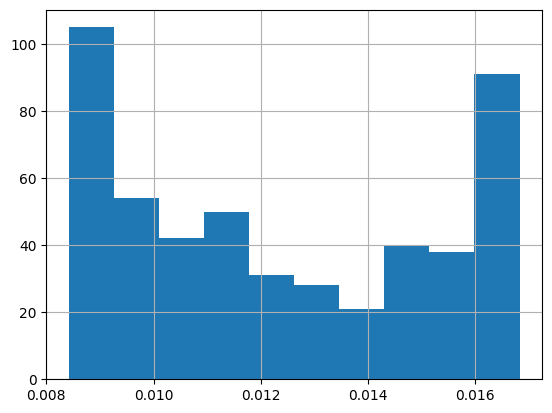

In [23]:
#drive.mount("/content/gdrive", force_remount=True)
filename = 'QED_data_e_annih_mu.csv'
dataset_size=500
#torch.save(0, osp.join(DATASET_PATH, f'processed/force_skip.pt'))
full_dataset = FeynmanDataset(dataset_size=dataset_size, filename=filename, num_sampling_bins=1, reprocess=True)

dataset_indices= np.arange(dataset_size)
rnd.shuffle(dataset_indices)
dataset_indices=dataset_indices.tolist()

print("Loading datasets...")
#60:20:20 split for train:val:test
train_dataset = full_dataset[dataset_indices[0:int(dataset_size*3/5)]]
val_dataset = full_dataset[dataset_indices[int(dataset_size*3/5):int(dataset_size*4/5)]]
test_dataset = full_dataset[dataset_indices[int(dataset_size*4/5):dataset_size]]
pred_dataset = full_dataset[dataset_indices[-10:dataset_size]]
print("Finished all!")

## Some loss functions
Defining some loss functions

In [24]:
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))

class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.L1 = nn.L1Loss()
        self.logcosh = LogCoshLoss()
    
    def forward(self, pred, actual):
      loss_value = self.mse(pred,actual)
      return loss_value

class Accuracy(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, pred, actual, dp):
    differences = np.abs(pred.cpu().detach().numpy() - actual.cpu().detach().numpy())
    differences = np.round(differences,dp)
    differences = torch.from_numpy(differences)
    acc = (differences.size()[0]-torch.count_nonzero(differences))/differences.size()[0]
    acc = acc*100
    
    return acc



## Training code and GNN model using Lightning Module

* Lightning training module
* Uses Transformer convolution layer

In [36]:
# Animation function
def animate(i,x,y,plot,temp):
    plot.set_data(x, y)

class FeynModel(pl.LightningModule):
    def __init__(self, c_in, layer_name, gnn_layer_dict, model_params, filename, dataset_size, num_sampling_bins, reprocess=False):
        """
        c_in = channels in (feature dimensions, e.g. RGB is 3)
        c_out = channels out (target dimension of the GRAPH REPRESENTATION, not the target)
        """
        super().__init__()
        
        #file properties
        self.filename=filename
        self.reprocess=reprocess
        self.dataset_size=dataset_size
        self.num_sampling_bins=num_sampling_bins

        #hyperparameters
        self.num_nodes = 6 #need to change this
        self.batch_size = model_params["batch_size"]
        embedding_size = model_params["embedding_size"]
        n_heads = model_params["attention_heads"]
        self.c_out = model_params["out_channels"]
        self.n_layers = model_params["layers"]
        dropout_rate = model_params["dropout_rate"]
        top_k_ratio =  model_params["top_k_ratio"]
        self.top_k_every_n = model_params["top_k_every_n"]
        dense_neurons = model_params["dense_neurons"]
        edge_dim = model_params["edge_dim"]
        self.lr = model_params["learning_rate"]
        self.lrs_step = model_params["lrs_step"]
        self.gamma = model_params["gamma"]
        self.weight_decay = model_params["weight_decay"]
        self.lin_dropout_prob = model_params["lin_dropout_prob"]
        self.SGD_momentum = model_params["momentum"]
        self.save_hyperparameters()

        #layer dictionary
        gnn_layer = gnn_layer_dict[layer_name]

        #layer module lists
        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        #loss and accuracy function
        self.loss_fn = MyLoss()
        self.L1_loss = nn.L1Loss()
        self.acc_fn = Accuracy()

        # First layer
        self.conv1 = gnn_layer(in_channels=c_in,
                               out_channels=embedding_size, 
                               heads=n_heads, 
                               dropout=dropout_rate,
                               edge_dim=edge_dim
                               ) 

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)
        self.pool1 = TopKPooling(embedding_size,ratio=top_k_ratio)

        # Middle layers
        for i in range(self.n_layers):
            self.conv_layers.append(gnn_layer(embedding_size, 
                                              embedding_size, 
                                              heads=n_heads, 
                                              dropout=dropout_rate,
                                              edge_dim=edge_dim,
                                              ))

            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
        
        #Final layer
        self.conv_fin = gnn_layer(in_channels=embedding_size,
                                  out_channels=self.c_out, 
                                  heads=n_heads, 
                                  dropout=dropout_rate,
                                  edge_dim=edge_dim
                                  )
        self.transf_fin = Linear(self.c_out*n_heads, self.c_out)
        self.bn_fin = BatchNorm1d(self.c_out)
        self.pool_fin = TopKPooling(self.c_out,ratio=1e-10)        

        # First linear layers
        #self.linear_reduce = Linear(embedding_size*2, self.c_out)
        self.linear0 = Linear(2+self.c_out, dense_neurons)
        #self.linear1 = Linear(2+embedding_size*2, dense_neurons)
        #self.linear_skip = Linear(2+self.c_out, 1)

        #Middle linear layers
        self.linear2 = Linear(dense_neurons, dense_neurons)
        self.linear3 = Linear(dense_neurons,int(dense_neurons/2))

        #Out linear layer
        #self.linear4 = Linear(int(dense_neurons), 1)
        self.linear5 = Linear(int(dense_neurons/2), 1)

        """
        could use super node instead of topKPooling and linear layers
        or more topK pooling rather than linear layers
        """
    def forward(self, x, edge_index, edge_attr, p, theta, batch_index):
        """
        exepects each element of the batch to be
        x - [6,1]
        edge_index - [2,num_edges (usually 10)]
        edge_attr - [num_edges (usually 10),9]
        p - [3,1]
        """
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = F.leaky_relu(self.transf1(x))
        #x = self.bn1(x)

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = F.leaky_relu(self.transf_layers[i](x))
            #x = self.bn_layers[i](x
            
        # Reduce graph representation to size of c_out
        x = self.conv_fin(x, edge_index, edge_attr)
        x = F.leaky_relu(self.transf_fin(x))
        #x = self.bn_fin(x)
        #x , edge_index, edge_attr, batch_index, _, _ = self.pool_fin(x, edge_index, edge_attr, batch_index)

        #Add all nodes together to get graph representation
        x=geom_nn.global_add_pool(x,batch_index)
        #print(x)

        #create dummy graph representation, always 1
        #x = torch.zeros((self.batch_size,1))

        # Concatenate with momentum
        x=x.view(-1,self.c_out)
        p=p.view(-1,1)
        theta=theta.view(-1,1)
        x = torch.cat((x, p),1)
        x = torch.cat((x,theta),1)

        # Output
        #print("0", x)
        x = F.leaky_relu(self.linear0(x))
        #print("1", x)
        x = F.dropout(x, p=self.lin_dropout_prob, training=self.training)
        x = F.leaky_relu(self.linear2(x))
        #print("2", x)
        x = F.dropout(x, p=self.lin_dropout_prob, training=self.training)
        x = F.leaky_relu(self.linear3(x))
        #print("3", x)
        x = F.dropout(x, p=self.lin_dropout_prob, training=self.training)
        x = torch.sigmoid(self.linear5(x))
        #print("4", x)
        return x

    def prepare_data(self):
      print("No data to download or prepare") 

    def setup(self, stage: Optional[str]):
      """
      I should edit this data to make the y values more num_sampling_binsly distributed across the range
      """
      print("Loading datasets...")
      #torch.save(0, osp.join(DATASET_PATH, f'processed/force_skip.pt'))
      self.full_dataset = FeynmanDataset(dataset_size=self.dataset_size, filename=self.filename, reprocess=self.reprocess, num_sampling_bins=self.num_sampling_bins)
      self.reprocess=False
      dataset_indices = [x for x in range(len(self.full_dataset))]
      rnd.shuffle(dataset_indices)
      
      #60:20:20 split for train:val:test
      self.train_dataset = self.full_dataset[dataset_indices[0:int(self.dataset_size*3/5)]]
      self.val_dataset = self.full_dataset[dataset_indices[int(self.dataset_size*3/5):int(self.dataset_size*4/5)]]
      self.test_dataset = self.full_dataset[dataset_indices[int(self.dataset_size*4/5):self.dataset_size]]
      print("Finished all!")

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_dataset, batch_size=len(self.test_dataset), num_workers=0)
    
    
    def training_step(self, batch, batch_idx):
        x, edge_index, edge_attr, y, p, theta = batch['x'], batch['edge_index'], batch['edge_attr'], batch['y'], batch['p'], batch['theta']
        batch_idx = batch['batch']
        y_hat = self(x,
                     edge_index,
                     edge_attr,
                     p,
                     theta,
                     batch_idx
        )
        loss = self.loss_fn(y_hat, y.view(-1,1))
        L1 = self.L1_loss(y_hat,y.view(-1,1))
        acc1 = self.acc_fn(y_hat, y.view(-1,1),1)
        acc2 = self.acc_fn(y_hat, y.view(-1,1),2)

        self.log("train_loss", L1, prog_bar=True, on_step=True, on_epoch=False, batch_size=max(batch_idx)+1)
        self.log("train_acc_1dp", acc1,prog_bar=False, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        self.log("train_acc_2dp", acc2,prog_bar=False, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)

        """
        fig, (ax)= plt.subplots(1,1)

        # Create variable reference to plot
        f_d, = ax.plot([], [], linewidth=2.5)
        # Add text annotation and create variable reference
        temp = ax.text(1, 1, '', ha='right', va='top', fontsize=24)

        # Create animation
        ani = FuncAnimation(fig=fig, func=animate, interval=500, repeat=True)
        """

        return loss


    def validation_step(self, batch, batch_idx):
        x, edge_index, edge_attr, y, p, theta = batch['x'], batch['edge_index'], batch['edge_attr'], batch['y'], batch['p'], batch['theta']
        batch_idx = batch['batch']
        y_hat = self(x,
                     edge_index,
                     edge_attr,
                     p,
                     theta,
                     batch_idx
        )
        loss = self.loss_fn(y_hat, y.view(-1,1))
        L1 = self.L1_loss(y_hat,y.view(-1,1))
        acc1 = self.acc_fn(y_hat, y.view(-1,1),1)
        acc2 = self.acc_fn(y_hat, y.view(-1,1),2)
        acc3 = self.acc_fn(y_hat, y.view(-1,1),3)


        self.log("val_loss", L1, prog_bar=True, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        self.log("val_acc_1dp", acc1,prog_bar=False, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        self.log("val_acc_2dp", acc2,prog_bar=False, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        self.log("val_acc_3dp", acc3,prog_bar=True, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)

        return loss



    def test_step(self, batch, batch_idx):
        x, edge_index, edge_attr, y, p, theta = batch['x'], batch['edge_index'], batch['edge_attr'], batch['y'], batch['p'], batch['theta']
        batch_idx = batch['batch']
        batch['y_scaler'].view(-1,1)
        y_hat = self(x,
                     edge_index,
                     edge_attr,
                     p,
                     theta,
                     batch_idx
        )

        loss = self.loss_fn(y_hat, y.view(-1,1))
        L1 = self.L1_loss(y_hat, y.view(-1,1))
        acc3 = self.acc_fn(y_hat, y.view(-1,1),3)
        acc2 = self.acc_fn(y_hat, y.view(-1,1),2)
        acc1 = self.acc_fn(y_hat, y.view(-1,1),1)

        self.log("test_acc_3dp", acc3, prog_bar=True, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        self.log("test_acc_2dp", acc2, prog_bar=False, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        self.log("test_acc_1dp", acc1, prog_bar=False, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        self.log("test_loss", L1, prog_bar=True, on_step=False, on_epoch=True, batch_size=max(batch_idx)+1)
        
        
        fig, (ax1,ax2) = plt.subplots(1,2)
        ax1.scatter(theta.cpu().numpy(), (y_hat).cpu().numpy()) 
        ax2.scatter(theta.cpu().numpy(), (y.view(-1,1)).cpu().numpy(),c='r')
        ax1.set_title("Predictions")
        ax1.set_xlabel("Theta /rad")
        ax1.set_ylabel(r"$|M_{fi}|^2$")
        ax2.set_title("Actual")
        ax2.set_xlabel("Theta /rad")
        ax2.set_ylabel(r"$|M_{fi}|^2$")
        plt.show()
        
        return loss

    def predict_step(self, batch, batch_idx):
        x, edge_index, edge_attr, y, p, theta= batch['x'], batch['edge_index'], batch['edge_attr'], batch['y'],batch['p'], batch['theta']
        batch_idx = batch['batch']
        scaler = batch['y_scaler']
        y_hat = self(x,
                     edge_index,
                     edge_attr,
                     p,
                     theta,
                     batch_idx
        )
        y_hat_plot = ((y_hat.view(-1)*scaler).cpu().numpy())
        y_plot = y*scaler.cpu().numpy()

        theta_order = theta.cpu().numpy().argsort()
        theta_plot = theta[theta_order]
        y_plot = y_plot[theta_order] #(((4*np.pi/137)*(1+np.cos(theta_ordered)))**2+((4*np.pi/137)*(1-np.cos(theta_ordered)))**2)/2
        
        plt.scatter(theta, y_hat_plot, c='b', marker="+", zorder=1)
        plt.plot(theta_plot, y_plot, c='r', linewidth=1.5 ,zorder=2)
        plt.title("Matrix Element")
        plt.xlabel("Theta /rad")
        plt.ylabel(r"$|M_{fi}|^2$")
        if min(y_plot)<0.1:
          pass
        else:
          min(y_plot)*0.8
        #plt.ylim([-0.1,max(y_plot)*1.1])
        plt.xlim([0,np.pi])
        plt.legend(["Actual","Predicted"])
        """
        
        fig, (ax1,ax2) = plt.subplots(1,2)
        ax1.scatter(theta.cpu().numpy(), (y_hat).cpu().numpy()) 
        ax2.scatter(theta.cpu().numpy(), y.view(-1,1).cpu().numpy(),c='r')
        """
        os.makedirs(f'{CHECKPOINT_PATH}/figs/', exist_ok=True)
        plt.savefig(f'{CHECKPOINT_PATH}/figs/',dpi=400, bbox_inches='tight')

        plt.show()

    def configure_optimizers(self):
      print('learning rate is ', self.lr)
      torch.optim.SGD(self.parameters(),
                             lr=self.lr,
                             weight_decay=self.weight_decay,
                             momentum=0.5
                             )
      fcn_optimizer = torch.optim.SGD(self.parameters(), #list(self.parameters())[-10:],
                             lr=self.lr,
                             weight_decay=self.weight_decay,
                             momentum=0.5
                             )
      torch.optim.lr_scheduler.StepLR(fcn_optimizer, step_size=self.lrs_step, gamma=self.gamma)

      optimizer = torch.optim.SGD(self.parameters(),lr=self.lr,weight_decay=self.weight_decay,
                                   momentum=self.SGD_momentum
                                   )
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=5,factor=self.gamma)
      return {'optimizer':optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

## Training function

In [37]:
#layer name dictionary
gnn_layer_dict = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv,
    "NNConv": geom_nn.NNConv,
    "RGCN": geom_nn.RGCNConv,
    "Trans": geom_nn.TransformerConv
}

def train_feyn(model_params, num_gpus, num_epochs, filename, dataset_size, num_sampling_bins, lr_tune=False, reprocess=False):
  """
  Function to train the Feynman GNN without a hyperparameter search.
  model_params = The hyperparameters to use, stored as a dictionary
  """

  if lr_tune is True:
    #need to make layer type a hyperparameter
    model = FeynModel(c_in=-1, #train_dataset.num_node_features 
                      layer_name="GAT",
                      gnn_layer_dict=gnn_layer_dict,
                      model_params=model_params,
                      dataset_size=dataset_size,
                      reprocess=reprocess,
                      filename=filename,
                      num_sampling_bins=num_sampling_bins
                      )
    trainer = pl.Trainer(logger=TensorBoardLogger(CHECKPOINT_PATH, name="tb_logs"),
                       max_epochs=num_epochs,
                       gpus=math.ceil(num_gpus),
                       log_every_n_steps=3,
                       auto_lr_find=True,
                       callbacks=[EarlyStopping('val_loss',patience=20)],
                       )
    # Run learning rate finder
    lr_finder = trainer.tuner.lr_find(model, min_lr=1e-8, max_lr=0.1)

    # Plot with
    fig = lr_finder.plot(suggest=True)
    fig.show()

    # Pick point based on plot, or get suggestion
    new_lr = lr_finder.suggestion()

    model_params['learning_rate']=new_lr
    print(new_lr)

  else:
    #need to make layer type a hyperparameter
    model = FeynModel(c_in=-1, #train_dataset.num_node_features 
                      layer_name="GAT",
                      gnn_layer_dict=gnn_layer_dict,
                      model_params=model_params,
                      dataset_size=dataset_size,
                      reprocess=reprocess,
                      filename=filename,
                      num_sampling_bins=num_sampling_bins
                      )
    
    trainer = pl.Trainer(logger=TensorBoardLogger(CHECKPOINT_PATH, name="tb_logs"),
                        max_epochs=num_epochs,
                        #gpus=math.ceil(num_gpus),
                        log_every_n_steps=1,
                        callbacks=[EarlyStopping('val_loss',patience=20)],
                        )

  trainer.fit(model)
  trainer.validate(model)
  trainer.test(model)

  return model, trainer

# Create parameters and train

* Check cuda
* Create layer dictionary and hyperparameters
* Choose the arguments for train_feyn()

Torch version: 2.0.1+cpu
Cuda available: False
Torch geometric version: 2.3.1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name           | Type        | Params
------------------------------------------------
0  | conv_layers    | ModuleList  | 160   
1  | transf_layers  | ModuleList  | 40    
2  | pooling_layers | ModuleList  | 0     
3  | bn_layers      | ModuleList  | 16    
4  | loss_fn        | MyLoss      | 0     
5  | L1_loss        | L1Loss      | 0     
6  | acc_fn         | Accuracy    | 0     
7  | conv1          | GATConv     | 64    
8  | transf1        | Linear      | 20    
9  | bn1            | BatchNorm1d | 8     
10 | pool1          | TopKPooling | 4     
11 | conv_fin       | GATConv     | 160   
12 | transf_fin     | Linear      | 72    
13 | bn_fin         | BatchNorm1d | 16    
14 | pool_fin       | TopKPooling | 8     
15 | linear0        | Linear      | 1.4 K 
16 | linear2        | Linear      | 16.5 K
17 | linear3        | Linear 

No data to download or prepare
Loading datasets...
Finished all!
learning rate is  1
Epoch 49: 100%|██████████| 19/19 [00:01<00:00, 11.93it/s, v_num=6, train_loss=0.016, val_loss=0.0102, val_acc_3dp=5.000]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 19/19 [00:01<00:00, 11.75it/s, v_num=6, train_loss=0.016, val_loss=0.0102, val_acc_3dp=5.000]
No data to download or prepare
Loading datasets...
Finished all!
Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 17.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.validating metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_acc_1dp                 100.0
       val_acc_2dp                 38.0
       val_acc_3dp                  4.0
        val_loss           0.008726566098630428
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
No data to download or prepare
Loading datasets...
Finished all!
Testing DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

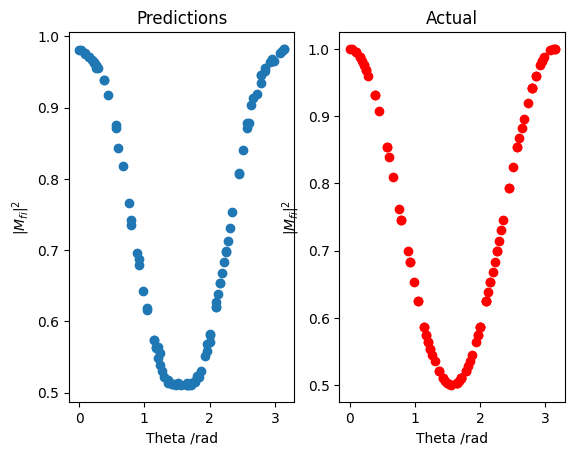

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_1dp                 100.0
      test_acc_2dp                 34.0
      test_acc_3dp                  6.0
        test_loss          0.009365097619593143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [46]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

if torch.cuda.is_available():
  gpus=1
else:
  gpus=0

#Hyperparameters to use if not tuning
HYPERPARAMETERS = {
    "batch_size": 16,
    "weight_decay": 0,
    "learning_rate": 1,
    "gamma": 5e-1,
    "lrs_step": 10,
    "momentum": 0.3,
    "out_channels": 8,
    "embedding_size": 4,
    "attention_heads": 1,
    "layers": 2, #number of hidden layers in GNN
    "dropout_rate": 0.5,
    "top_k_ratio": 0.1,
    "top_k_every_n": 1,
    "dense_neurons": 128,
    "edge_dim": 12,
    "lin_dropout_prob": 0.1,
    }

model, trainer = train_feyn(HYPERPARAMETERS,
                            gpus,
                            num_epochs=50,
                            filename='QED_data_e_annih_mu.csv',
                            lr_tune=False,
                            reprocess=False,
                            dataset_size=500,
                            num_sampling_bins=5)

## Predictions
Make the prediction datasets and make predictions with the last model

No data to download or prepare
Loading datasets...
Finished all!
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

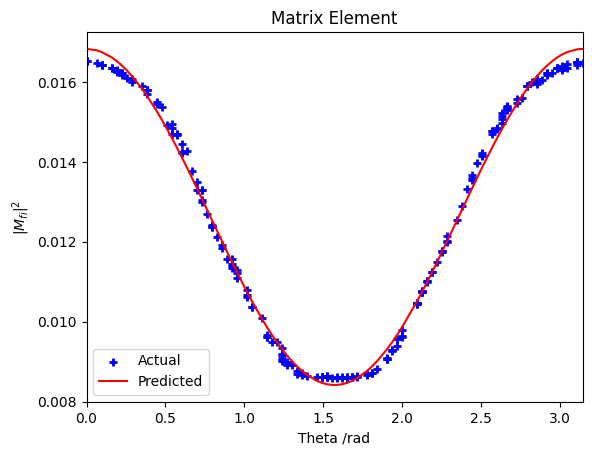

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


In [47]:
filename = 'QED_data_e_annih_mu.csv'
dataset_size=200
pred_dataset = FeynmanDataset(dataset_size=dataset_size, filename=filename, num_sampling_bins=1, reprocess=False)
pred_loader_mu = DataLoader(pred_dataset, batch_size=len(pred_dataset))

filename = 'QED_data_e_annih_e.csv'
dataset_size=200
pred_dataset = FeynmanDataset(dataset_size=dataset_size, filename=filename, num_sampling_bins=1, reprocess=False)
pred_loader_e = DataLoader(pred_dataset, batch_size=len(pred_dataset))

out = trainer.predict(model, pred_loader_mu)

## Load a specific model
(Disabled for now)

In [ ]:
#load the predictor model with weights from best_path
"""
best_path = "/content/gdrive/MyDrive/Part_III_Project/saved_models/best_models/version_133/checkpoints/epoch=52-step=1007.ckpt"
model_params = {k: v[0] for k, v in HYPERPARAMETERS.items() if k.startswith("model_")}

#pretrained_model = FeynModel(c_in=-1,c_out=1, layer_name='GAT', model_params=model_params).load_from_checkpoint(best_path)
pretrained_model = FeynModel.load_from_checkpoint(best_path)
pred_trainer = pl.Trainer(logger=TensorBoardLogger(CHECKPOINT_PATH, name="tb_logs"))
pred_trainer.predict(pretrained_model, pred_loader_mu)
"""

"""#**TensorBoard Logs and running training**

"""

# Commented out IPython magic to ensure Python compatibility.
%tensorboard --logdir /content/gdrive/MyDrive/Part_III_Project/saved_models/tb_logs